**Q3**

Imports for this part:

In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import ast
from collections import Counter
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_rel
#import re 
#from bs4 import BeautifulSoup 
#from datetime import datetime
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#import ast

Get the dataset:

In [2]:
folder = "generated/"

df_movies=pd.read_csv(folder + "USE_THIS_DATASET.csv", index_col = 'Wikipedia movie ID')
df_movies['decade'] = (df_movies['Movie release year'] // 10) * 10

Keep what is usefull for this part and save it to a csv file:

In [40]:
# keep what is usefull for part 3
df_3 = df_movies.copy()

df_3 = df_3.drop(['Movie release month', 'Movie release date', 'Movie runtime', 'Movie languages', 'Compound Score'], axis=1)

df_3 = df_3.dropna(subset=['Movie box office revenue','Movie release year'])

df_3['Movie release year'] = df_3['Movie release year'].astype(int)

# Convert string representations of lists into actual lists
#df_3['Movie countries'] = df_3['Movie countries'].apply(ast.literal_eval)
df_3['Movie genres'] = df_3['Movie genres'].apply(ast.literal_eval)

#df_3 = df_3[df_3['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [41]:
# Verification: Check if there are any remaining empty strings
print("Remaining empty strings per column:")
print((df_3 == '').sum())

Remaining empty strings per column:
Movie name                  0
Movie release year          0
Movie box office revenue    0
Movie countries             0
Movie genres                0
Summary                     0
Sentiment                   0
Theme                       0
vote_average                0
budget                      0
decade                      0
dtype: int64


In [42]:
#Get rid of Box office oulier
threshold = df_3['Movie box office revenue'].quantile(0.99)
df_3 = df_3[df_3['Movie box office revenue'] <= threshold]

In [43]:
#Themes correction

df_3['Theme'] = df_3['Theme'].str.lower()

corrections = { 
    "ransformation": "transformation",
    "ransition": "transition",
    "ptation": "temptation",
    "ragedy": "tragedy",
    "ranscendence": "transcendence",
    "radition": "tradition",
    "ransport": "transport",
    "ransgression": "transgression",
    "ransmutation": "transmutation",
    "ransparency": "transparency",
    "ransportation": "transportation",
    "ransmigration": "transmigration",
    "rture": "torture",
    "rritory": "territory",
    "rafficking": "trafficking",
    "vriendschap": "friendship",
    "vengeance": "revenge" #grouping for analysis
}

# Function to correct themes
def correct_theme(theme):
    if pd.isna(theme):  # Handle NaN values
        return theme
    return corrections.get(theme, theme)  # Apply correction if it exists

# Apply the correction to the 'Theme' column
df_3['Corrected_Theme'] = df_3['Theme'].apply(correct_theme)

In [44]:
df_3 = df_3.drop(['Theme'], axis = 1) 

In [45]:
# Save to a csv file
df_3.to_csv('df_3.csv')

In [8]:
# Check for missing values
print(df_3.isna().sum())

Movie name                     0
Movie release year             0
Movie box office revenue       0
Movie countries                0
Movie genres                   0
Summary                      155
Sentiment                    155
vote_average                1077
budget                      4880
decade                         0
Corrected_Theme              167
dtype: int64


In [9]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10827 entries, 975900 to 26482675
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie name                10827 non-null  object 
 1   Movie release year        10827 non-null  int64  
 2   Movie box office revenue  10827 non-null  float64
 3   Movie countries           10827 non-null  object 
 4   Movie genres              10827 non-null  object 
 5   Summary                   10672 non-null  object 
 6   Sentiment                 10672 non-null  object 
 7   vote_average              9750 non-null   float64
 8   budget                    5947 non-null   float64
 9   decade                    10827 non-null  float64
 10  Corrected_Theme           10660 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 1015.0+ KB


In [10]:
# Useful functions

# Function to calculate confidence intervals 
def calculate_ci(data, confidence=0.99):
    # Calculate the standard error of the mean (SEM)
    sem = stats.sem(data, nan_policy='omit')
    # Calculate the margin of error
    margin_of_error = sem * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return margin_of_error

In [11]:
# Useful general objects

total_movies_per_year = df_3.groupby('Movie release year').size()

box_office_per_year = df_3.groupby('Movie release year')['Movie box office revenue'].mean()

# Calculate CI for total movies per year
total_movies_ci_upper = total_movies_per_year + calculate_ci(total_movies_per_year)
total_movies_ci_lower = total_movies_per_year - calculate_ci(total_movies_per_year)

all_movies_revenue_stats = df_3['Movie box office revenue'].describe()

**LGBT related movies**

In [ ]:
# List of LGBT-related genres
lgbt_genres = [
    'LGBT', 'Gay Interest', 'New Queer Cinema', 'Gay Themed', 'Queer Cinema', 'Gender Issues', 'Gay'
]

# Filter the movies with the LGBT-related genres
lgbt_movies = df_3[df_3['Movie genres'].apply(lambda genres: any(g in genres for g in lgbt_genres))]

#Get rid of Box office oulier
#threshold = lgbt_movies['Movie box office revenue'].quantile(0.99)
#lgbt_movies = lgbt_movies[lgbt_movies['Movie box office revenue'] <= threshold]

# Group by release year and count movies
lgbt_per_year = lgbt_movies.groupby('Movie release year').size()

normalized_lgbt = lgbt_per_year / total_movies_per_year

# Calculate CI for LGBT movies per year
lgbt_movies_ci_upper = lgbt_per_year + calculate_ci(lgbt_per_year)
lgbt_movies_ci_lower = lgbt_per_year - calculate_ci(lgbt_per_year)

lgbt_movies.info()

In [ ]:
# Save to a csv file
lgbt_movies.to_csv('lgbt_movies.csv')

In [ ]:
# Plot the number of LGBT-related movies released over time
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='gray', linestyle='--', label='Total Movies')
#ax1.fill_between(total_movies_per_year.index, total_movies_ci_lower, total_movies_ci_upper, color='gray', alpha=0.2)
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot LGBT movies
ax2 = ax1.twinx()
ax2.plot(lgbt_per_year.index, lgbt_per_year.values, color='purple', linewidth=2, label='LGBT Movies')
#ax2.fill_between(lgbt_per_year.index, lgbt_movies_ci_lower, lgbt_movies_ci_upper, color='purple', alpha=0.2)
ax2.set_ylabel('LGBT Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Evolution of LGBT Movies vs Total Movies Over Time', fontsize=16)
ax1.set_xlim(1960, 2010)
ax1.grid(alpha=0.5)

plt.tight_layout()
plt.savefig('visuals/NbLGBTMovies_ReleaseYear.png')
plt.show()

AIDS pandemic 1987–2000

From 2000's same-sex marriage, vote in 2015 for the US

In [ ]:
# Smooth the normalized LGBT data using a rolling window (e.g., 3 years)
normalized_lgbt_smooth = normalized_lgbt.rolling(window=3).mean()

# Plot smoothed normalized LGBT data
plt.figure(figsize=(10, 6))
plt.plot(normalized_lgbt.index, normalized_lgbt_smooth.values, color='purple', linewidth=2, label='Smoothed Normalized LGBT Movies')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Smoothed Normalized LGBT Movies', fontsize=14)
plt.title('Smoothed Normalized LGBT Movies Over Time', fontsize=16)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


Let's talk money:

In [ ]:
print("\nAll Movies Box Office Revenue Statistics:")
print(all_movies_revenue_stats)

In [ ]:
lgbt_revenue_stats = lgbt_movies['Movie box office revenue'].describe()
print("LGBT Movies Box Office Revenue Statistics:")
print(lgbt_revenue_stats)

In [ ]:
# Create a new column to classify movies
df_3['LGBT Related'] = df_3['Movie genres'].apply(
    lambda genres: any(g in genres for g in lgbt_genres)
)

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_3, x='LGBT Related', y='Movie box office revenue', palette='Set2')
plt.yscale('log')  # Use log scale if revenue values vary widely
plt.title('Box Office Revenue Comparison: LGBT-Related vs All Movies', fontsize=16)
plt.xlabel('Movie Type', fontsize=14)
plt.ylabel('Box Office Revenue (Log Scale)', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# KDE for all movies
sns.kdeplot(df_3['Movie box office revenue'], label='All Movies', color='blue', fill=True, alpha=0.3)

# KDE for LGBT-related movies
sns.kdeplot(lgbt_movies['Movie box office revenue'], label='LGBT Movies', color='purple', fill=True, alpha=0.3)

plt.xscale('log')  # Use log scale for better visualization
plt.title('Revenue Distribution: LGBT Movies vs All Movies', fontsize=16)
plt.xlabel('Box Office Revenue (Log Scale)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Revenue data
lgbt_revenue = lgbt_movies['Movie box office revenue'].dropna()
all_movies_revenue = df_3['Movie box office revenue'].dropna()

# Perform T-test
t_stat, p_value = ttest_ind(lgbt_revenue, all_movies_revenue, equal_var=False)
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("The difference in box office revenues is statistically significant.")
else:
    print("No significant difference in box office revenues.")


In [ ]:
lgbt_box_office_per_year = lgbt_movies.groupby('Movie release year')['Movie box office revenue'].mean()

# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(box_office_per_year.index, box_office_per_year.values, label='All Movies', color='blue')
plt.plot(lgbt_box_office_per_year.index, lgbt_box_office_per_year.values, label='LGBT Movies', color='purple')
plt.title('Average Box Office Revenue Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue', fontsize=14)
plt.xlim(1940, 2010)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Flatten the list of genres and filter out LGBT-related genres
all_genres = [genre for genres in lgbt_movies['Movie genres'] for genre in genres if genre not in lgbt_genres]

# Count occurrences of non-LGBT genres
genre_counts = Counter(all_genres)

# Extract the top 10 most common non-LGBT genres
top_10_non_lgbt_genres = genre_counts.most_common(10)

print("Top 10 Non-LGBT Genres in LGBT Movies:")
for genre, count in top_10_non_lgbt_genres:
    print(f"{genre}: {count}")



In [ ]:
genres, counts = zip(*top_10_non_lgbt_genres)
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='purple', alpha=0.7)
plt.title('Top 10 Non-LGBT Genres in LGBT Movies', fontsize=16)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Count movies by country for all movies
all_countries = lgbt_movies['Movie countries'].explode().value_counts()

# Compare top countries
print("Top Countries for LGBT Movies:")
print(all_countries.head(10))


In [ ]:
# Count non-LGBT genres in LGBT movies
non_lgbt_genres = [genre for genres in lgbt_movies['Movie genres'] for genre in genres if genre not in lgbt_genres]
non_lgbt_genre_counts = Counter(non_lgbt_genres)

# Count all genres in all movies
all_genres = [genre for genres in df_3['Movie genres'] for genre in genres]
all_genre_counts = Counter(all_genres)

# Top 10 non-LGBT genres in LGBT movies
top_non_lgbt_genres = dict(non_lgbt_genre_counts.most_common(10))

# Top 10 genres in all movies
top_all_genres = dict(all_genre_counts.most_common(10))

# Combine into a DataFrame for easier comparison
comparison_df = pd.DataFrame({
    'Non-LGBT Genres in LGBT Movies': top_non_lgbt_genres,
    'Genres in All Movies': top_all_genres
}).fillna(0)  # Fill missing values with 0


comparison_df.plot(kind='bar', figsize=(12, 6), color=['purple', 'gray'], alpha=0.7)
plt.title('Top Genres Comparison: Non-LGBT in LGBT Movies vs All Movies', fontsize=16)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Identify the top 3 non-LGBT genres
top_3_non_lgbt_genres = [genre for genre, count in Counter(non_lgbt_genres).most_common(3)]
print("Top 3 Non-LGBT Genres in LGBT Movies:", top_3_non_lgbt_genres)

# Step 3: Create a DataFrame to track genre occurrences over time
# Initialize an empty DataFrame
genre_trends = pd.DataFrame()

# Loop through the top 3 genres and count occurrences per year
for genre in top_3_non_lgbt_genres:
    genre_trends[genre] = lgbt_movies.apply(
        lambda row: genre in row['Movie genres'], axis=1
    ).groupby(lgbt_movies['Movie release year']).sum()

# Step 4: Plot the trends
plt.figure(figsize=(12, 6))
for genre in top_3_non_lgbt_genres:
    plt.plot(genre_trends.index, genre_trends[genre], label=genre, linewidth=2)

# Customize the plot
plt.title('Evolution of Top 3 Non-LGBT Genres Associated with LGBT Movies Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.legend(title='Genres', fontsize=12)
plt.grid(alpha=0.5)
plt.xlim(1960, 2010)  # Adjust based on the range of years in your dataset
plt.tight_layout()
plt.show()

In [ ]:
### Pas marche !

# Initialize an empty list to store the results
data = []

# Loop through each year and find the top 3 genres
for year, group in lgbt_movies.groupby('Movie release year'):
    # Flatten the genres for this year and filter out LGBT-related genres
    genres_in_year = [
        genre for genres in group['Movie genres'] for genre in genres if genre not in lgbt_genres
    ]
    # Count occurrences of each genre
    genre_counts = Counter(genres_in_year)
    # Get the top 3 genres
    for genre, count in genre_counts.most_common(5):
        data.append({'Year': year, 'Genre': genre, 'Count': count})

# Convert the results into a DataFrame
plot_data = pd.DataFrame(data)

# Step 3: Create the dynamic bar chart using Plotly
fig = px.bar(
    plot_data,
    x='Genre',
    y='Count',
    color='Genre',
    animation_frame='Year',
    title='Top 3 Non-LGBT Genres in LGBT Movies Over Time',
    labels={'Count': 'Number of Movies', 'Genre': 'Genre'},
    height=600
)

# Customize layout
fig.update_layout(
    xaxis=dict(title='Genre'),
    yaxis=dict(title='Number of Movies'),
    legend_title='Genre',
    title_font_size=18,
    title_x=0.5
)

# Show the interactive plot
fig.show()

In [ ]:
# Identify outliers for LGBT movies
lgbt_outliers = lgbt_movies[lgbt_movies['Movie box office revenue'] > lgbt_movies['Movie box office revenue'].quantile(0.95)]
print("Outliers in LGBT Movies Revenue:")
print(lgbt_outliers[['Movie name', 'Movie box office revenue', 'Movie release year']])

# Identify outliers for all movies
# all_outliers = df_3[df_3['Movie box office revenue'] > df_3['Movie box office revenue'].quantile(0.99)]
# print("\nOutliers in All Movies Revenue:")
# print(all_outliers[['Movie name', 'Movie box office revenue', 'Movie release year']])

### Need to link outliers to plot for LGBT-related movies i.e Lawrence of Arabia in 1963 and Cat on a Hot Tin Roof in 1958 only movies in these years!


In [ ]:

lgbt_1958 = lgbt_movies[lgbt_movies['Movie release year'] == 1958]
lgbt_1958

lgbt_1962 = lgbt_movies[lgbt_movies['Movie release year'] == 1962]
lgbt_1962

**War-related movies**

In [12]:
#War related movies

# List of genres related to LGBT themes
war_genres = [
    'War film', 'Combat films', 'Anti-War film', 'Gulf War', 'Cold War', 'Nuclear warfare', 'War effort', 'Anti-war'
]

# Create a binary column: 1 for war-related movies, 0 for non-war movies
df_3['War Related'] = df_3['Movie genres'].apply(lambda genres: any(g in genres for g in war_genres))

war_movies = df_3[df_3['Movie genres'].apply(lambda genres: any(g in genres for g in war_genres))]

war_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 539 entries, 171005 to 1142326
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie name                539 non-null    object 
 1   Movie release year        539 non-null    int64  
 2   Movie box office revenue  539 non-null    float64
 3   Movie countries           539 non-null    object 
 4   Movie genres              539 non-null    object 
 5   Summary                   532 non-null    object 
 6   Sentiment                 532 non-null    object 
 7   vote_average              488 non-null    float64
 8   budget                    311 non-null    float64
 9   decade                    539 non-null    float64
 10  Corrected_Theme           529 non-null    object 
 11  War Related               539 non-null    bool   
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 51.1+ KB


In [13]:
# Save to a csv file
war_movies.to_csv('war_movies.csv')

In [ ]:
# Group by release year and count movies
war_per_year = war_movies.groupby('Movie release year').size()


# Plot the number of War-related movies released over time
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='gray', linestyle='--', label='Total Movies')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot LGBT movies
ax2 = ax1.twinx()
ax2.plot(war_per_year.index, war_per_year.values, color='purple', linewidth=2, label='LGBT Movies')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Evolution of War Movies vs Total Movies Over Time', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

plt.tight_layout()
plt.savefig('visuals/NbWarMovies_ReleaseYear.png')
plt.show()

In [ ]:
# Group by year and calculate average box office revenue for war movies
war_revenue_per_year = war_movies.groupby('Movie release year')['Movie box office revenue'].mean()

# Group by year and calculate average box office revenue for all movies
all_revenue_per_year = df_3.groupby('Movie release year')['Movie box office revenue'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(war_revenue_per_year.index, war_revenue_per_year.values, label='War Movies', color='red', linewidth=2)
plt.plot(all_revenue_per_year.index, all_revenue_per_year.values, label='All Movies', color='gray', linestyle='--', linewidth=2)
plt.title('Average Box Office Revenue: War Movies vs All Movies', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Example of annotating World War II and Vietnam War
plt.figure(figsize=(12, 6))
plt.plot(war_revenue_per_year.index, war_revenue_per_year.values, label='War Movies', color='red', linewidth=2)

# Annotate World War II (1939-1945)
plt.axvspan(1939, 1945, color='gray', alpha=0.3, label='World War II')
plt.text(1942, max(war_revenue_per_year) * 0.9, 'WWII', color='black', fontsize=12)

# Annotate Vietnam War (1955-1975)
plt.axvspan(1955, 1975, color='blue', alpha=0.1, label='Vietnam War')
plt.text(1965, max(war_revenue_per_year) * 0.8, 'Vietnam War', color='black', fontsize=12)

plt.title('Average Box Office Revenue of War Movies with Historical Events', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Revenue ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Extract box office revenue
war_revenue = war_movies['Movie box office revenue'].dropna()
all_revenue = df_3['Movie box office revenue'].dropna()

# Perform a T-Test
t_stat, p_value = ttest_ind(war_revenue, all_revenue, equal_var=False)
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
    print("The difference in revenue is statistically significant.")
else:
    print("No statistically significant difference in revenue.")

C:\Users\elsap\AppData\Local\Temp\ipykernel_8972\1113496485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_3, x='War Related', y='Movie box office revenue', palette='Set2')


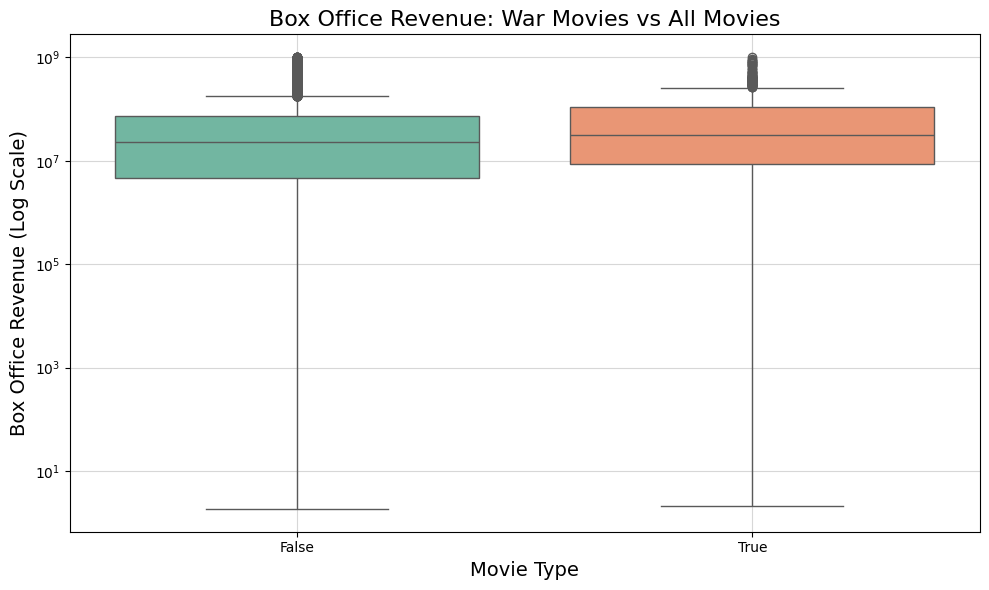

In [15]:
# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_3, x='War Related', y='Movie box office revenue', palette='Set2')
plt.yscale('log')  # Use log scale to handle outliers
plt.title('Box Office Revenue: War Movies vs All Movies', fontsize=16)
plt.xlabel('Movie Type', fontsize=14)
plt.ylabel('Box Office Revenue (Log Scale)', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Initialize a dictionary to store genre counts over time
genre_trends = {genre: [] for genre in war_genres}
years = sorted(war_movies['Movie release year'].unique())

# Step 3: Count occurrences of each war genre for each year
for year in years:
    # Filter war movies for the current year
    movies_in_year = war_movies[war_movies['Movie release year'] == year]
    
    # Flatten the genre list for the year and count war-related genres
    genres_in_year = [
        genre for genres in movies_in_year['Movie genres'] for genre in genres if genre in war_genres
    ]
    year_counts = Counter(genres_in_year)
    
    # Store counts for each genre
    for genre in war_genres:
        genre_trends[genre].append(year_counts.get(genre, 0))

# Step 4: Create a DataFrame for visualization
genre_trends_df = pd.DataFrame(genre_trends, index=years)

# Step 5: Create an interactive stacked area chart with Plotly
fig = go.Figure()

# Add each genre as a trace
for genre in war_genres:
    fig.add_trace(go.Scatter(
        x=genre_trends_df.index,
        y=genre_trends_df[genre],
        mode='lines',
        stackgroup='one',  # Stacked area chart
        name=genre
    ))

# Customize layout
fig.update_layout(
    title='Interactive Repartition of War Genres Over Time',
    xaxis=dict(title='Release Year'),
    yaxis=dict(title='Number of Movies'),
    legend=dict(title='War Genres'),
    hovermode='x unified',
    template='plotly_white'
)

# Show the interactive plot
fig.show()

In [ ]:
#Hero-related movies

# List of genres related to LGBT themes
hero_genres = [
    'Superhero', 'Superhero movie'
]

hero_movies = df_3[df_3['Movie genres'].apply(lambda genres: any(g in genres for g in hero_genres))]

hero_movies.info()

In [ ]:
# Group by release year and count movies
heros_per_year = hero_movies.groupby('Movie release year').size()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(heros_per_year.index, heros_per_year.values, linestyle='-', color='purple')
plt.title('Number of Superhero Movies Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xlim(1970, 2010)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
war_no_hero_movies = df_3[df_3['Movie genres'].apply(
    lambda genres: any(g in genres for g in war_genres) and not any(g in genres for g in hero_genres))
]

war_no_hero_movies.info()

In [ ]:
# Group by release year and count movies
war_no_hero_per_year = war_no_hero_movies.groupby('Movie release year').size()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(war_no_hero_per_year.index, war_no_hero_per_year.values, linestyle='-', color='purple')
plt.title('Number of War Movies without Superhero Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xlim(1920, 2010)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Check theme distribution
war_no_hero_theme_counts = war_no_hero_movies['Corrected_Theme'].value_counts()

# Plot the most common themes
war_no_hero_theme_counts.head(10).plot(kind='bar', color='green', figsize=(10, 6))
plt.title('Most Common Themes in War-Related Movies', fontsize=16)
plt.xlabel('Themes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Combine data into a single DataFrame for easier plotting
box_office_data = [
    (lgbt_movies['Movie box office revenue'].dropna(), 'LGBT'),
    (war_movies['Movie box office revenue'].dropna(), 'War'),
    (hero_movies['Movie box office revenue'].dropna(), 'Superhero')
]

# Create a DataFrame for plotting
box_office_df = pd.concat([pd.DataFrame({'Revenue': data[0], 'Category': data[1]}) for data in box_office_data])

# Plot violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Revenue', y='Category', data=box_office_df, palette='muted')
plt.title('Box Office Revenue Distribution by Category', fontsize=16)
plt.xlabel('Revenue (USD)', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Plot histograms for each category
plt.figure(figsize=(12, 6))
sns.histplot(lgbt_movies['Movie box office revenue'].dropna(), label='LGBT', color='purple', kde=True, bins=30)
sns.histplot(war_movies['Movie box office revenue'].dropna(), label='War', color='blue', kde=True, bins=30)
sns.histplot(hero_movies['Movie box office revenue'].dropna(), label='Superhero', color='green', kde=True, bins=30)
plt.title('Box Office Revenue Distribution by Category', fontsize=16)
plt.xlabel('Revenue (USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Calculate mean revenues
mean_revenues = {
    #'LGBT': lgbt_movies['Movie box office revenue'].mean(),
    'War': war_movies['Movie box office revenue'].mean(),
    'Superhero': hero_movies['Movie box office revenue'].mean()
}

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(list(mean_revenues.keys()), list(mean_revenues.values()), color=['blue', 'green'])
plt.title('Mean Box Office Revenue by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Mean Revenue (USD)', fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(12, 6))
#plt.scatter(lgbt_movies['Movie release year'], lgbt_movies['Movie box office revenue'], color='purple', label='LGBT', alpha=0.6)
plt.scatter(war_movies['Movie release year'], war_movies['Movie box office revenue'], color='blue', label='War', alpha=0.6)
plt.scatter(hero_movies['Movie release year'], hero_movies['Movie box office revenue'], color='green', label='Superhero', alpha=0.6)
plt.title('Box Office Revenue vs. Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Revenue (USD)', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Prepare box office data for the subsets
box_office_data = [
    #lgbt_movies['Movie box office revenue'].dropna().values,
    war_movies['Movie box office revenue'].dropna().values,
    hero_movies['Movie box office revenue'].dropna().values
]

# Ensure all data is numeric and non-empty
filtered_data = [data for data in box_office_data if len(data) > 0]
labels = [ 'War', 'Superhero'][:len(filtered_data)]  # Adjust labels dynamically

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, orient='h', palette='Set2')
plt.yticks(range(len(labels)), labels)  # Dynamically adjust labels
plt.title('Box Office Revenue Comparison', fontsize=16)
plt.xlabel('Revenue (USD)', fontsize=14)
plt.tight_layout()
plt.show()


Exploratory analysis


In [ ]:
# Check theme distribution
lgbt_theme_counts = lgbt_movies['Corrected_Theme'].value_counts()

# Plot the most common themes
lgbt_theme_counts.head(10).plot(kind='bar', color='green', figsize=(10, 6))
plt.title('Most Common Themes in LGBT-Related Movies', fontsize=16)
plt.xlabel('Themes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import f_oneway, ttest_ind

# Compare average box office revenue across subsets
anova_result = f_oneway(
    lgbt_movies['Movie box office revenue'].dropna(),
    war_movies['Movie box office revenue'].dropna(),
    hero_movies['Movie box office revenue'].dropna()
)
print(f"ANOVA result (p-value): {anova_result.pvalue}")

# Pairwise t-test between LGBT and superhero movies
t_test_result = ttest_ind(
    lgbt_movies['Movie box office revenue'].dropna(),
    hero_movies['Movie box office revenue'].dropna()
)
print(f"T-test result (p-value): {t_test_result.pvalue}")


In [ ]:
# Heatmap of average sentiment vs box office revenue
sentiment_revenue = df_3.groupby('Sentiment')['Movie box office revenue'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_revenue.index, y=sentiment_revenue.values, palette='coolwarm')
plt.title('Average Box Office Revenue by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Average Revenue', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Check for missing or zero ratings in the 'vote_average' column
print(lgbt_movies['vote_average'].isna().sum())  # Count of missing values
print((lgbt_movies['vote_average'] == 0).sum())  # Count of zero ratings

# Filter out rows with missing or zero ratings
lgbt_movies_filtered = lgbt_movies[(lgbt_movies['vote_average'] > 0) & (lgbt_movies['vote_average'].notna())]

In [ ]:
# Group by release year and calculate mean box office revenue and ratings
lgbt_success_over_time = lgbt_movies_filtered.groupby('Movie release year').agg(
    avg_revenue=('Movie box office revenue', 'mean'),
    avg_rating=('vote_average', 'mean')
).reset_index()

# Plot average box office revenue and ratings over time
plt.figure(figsize=(12, 6))

# Plotting average revenue
plt.plot(lgbt_success_over_time['Movie release year'], lgbt_success_over_time['avg_revenue'], label='Average Box Office Revenue', color='purple')

# Plotting average ratings
plt.plot(lgbt_success_over_time['Movie release year'], lgbt_success_over_time['avg_rating'], label='Average Viewer Rating', color='blue')

# Titles and labels
plt.title('LGBT Movies Success Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Value', fontsize=14)

# Add legend
plt.legend()

# Grid for better readability
plt.grid(alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
lgbt_movies[lgbt_movies['Movie box office revenue'] > 200000000]

In [ ]:
# Flatten list of genres while excluding LGBT-related ones
other_genres = lgbt_movies['Movie genres'].apply(eval).explode()
non_lgbt_genres = other_genres[~other_genres.isin(lgbt_genres)]
genre_counts = Counter(non_lgbt_genres)

# Display the 10 most common genres associated with LGBT movies
print(genre_counts.most_common(10))

In [ ]:
# Step 1: Count theme frequencies
theme_counts = lgbt_movies['Corrected_Theme'].value_counts()

# Step 2: Display the top 10 themes
print(theme_counts.head(10))


In [ ]:
# Step 1: Group by release year and sentiment, normalize to get proportions
sentiment_over_time = lgbt_movies.groupby(['Movie release year', 'Sentiment']).size().unstack(fill_value=0)
sentiment_proportions = sentiment_over_time.div(sentiment_over_time.sum(axis=1), axis=0)

# Step 2: Create the stacked area plot
plt.figure(figsize=(12, 6))
plt.stackplot(
    sentiment_proportions.index,  # Years
    sentiment_proportions['positive'], 
    sentiment_proportions['neutral'], 
    sentiment_proportions['negative'], 
    labels=['Positive', 'Neutral', 'Negative'], 
    colors=['green', 'gray', 'red']
)

# Add titles and labels
plt.title('Sentiment Proportions in LGBT Movies Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Step 2: Create the stacked bar chart
plt.figure(figsize=(12, 6))

# Create stacked bars
bar_width = 0.8
years = sentiment_proportions.index
positive = sentiment_proportions['positive']
neutral = sentiment_proportions['neutral']
negative = sentiment_proportions['negative']

plt.bar(years, positive, label='Positive', color='green', width=bar_width)
plt.bar(years, neutral, bottom=positive, label='Neutral', color='gray', width=bar_width)
plt.bar(years, negative, bottom=positive + neutral, label='Negative', color='red', width=bar_width)

# Add titles and labels
plt.title('Sentiment Proportions in LGBT Movies Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Count the total number of movies per year
lgbt_movies_per_year = lgbt_movies.groupby('Movie release year').size()

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary plot: Stacked area for sentiment proportions
ax1.stackplot(
    sentiment_proportions.index, 
    sentiment_proportions['positive'], 
    sentiment_proportions['neutral'], 
    sentiment_proportions['negative'], 
    labels=['Positive', 'Neutral', 'Negative'], 
    colors=['green', 'gray', 'red']
)
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Proportion', fontsize=14)
ax1.set_title('Sentiment Proportions in LGBT Movies Over Time', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(alpha=0.5)

# Secondary y-axis: Number of movies per year
ax2 = ax1.twinx()
ax2.plot(movies_per_year.index, movies_per_year.values, color='blue', label='Number of Movies')
ax2.set_ylabel('Number of Movies', fontsize=14)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Highlight years with low movie counts
low_data_threshold = 5
limited_data_years = movies_per_year[movies_per_year < low_data_threshold].index
print(f"Years with limited data: {limited_data_years.tolist()}")


In [ ]:
# Calculate standard deviation for error bars
sentiment_std = lgbt_movies.groupby(['Movie release year', 'Sentiment']).size().unstack(fill_value=0).std(axis=1)

# Example: Adding error bars to a bar chart
plt.bar(
    sentiment_proportions.index, 
    sentiment_proportions['positive'], 
    yerr=sentiment_std, 
    label='Positive', 
    color='green'
)

In [ ]:
sentiment_proportions.reset_index().plot.scatter(x='Movie release year', y='positive', c='green', label='Positive')


**War movies**

In [ ]:
print(f"Number of War Movies: {len(war_movies)}")
war_movies.info()

In [ ]:
# Summary statistics for box office revenue and viewer ratings
print(war_movies[['Movie box office revenue', 'vote_average']].describe())

# Check for missing values
print(war_movies.isna().sum())

In [ ]:
# Group by release year
war_movies_trends = war_movies.groupby('Movie release year').agg(
    num_movies=('Movie name', 'count'),
    avg_revenue=('Movie box office revenue', 'mean'),
    avg_rating=('vote_average', 'mean')
).reset_index()

# Display the first few rows
print(war_movies_trends.head())


In [ ]:
# Split genres and count occurrences of non-war genres
from collections import Counter

# Flatten the list of genres while excluding war-related genres
other_genres = war_movies['Movie genres'].apply(eval).explode()
non_war_genres = other_genres[~other_genres.isin(war_genres)]
genre_counts = Counter(non_war_genres)

# Display the top 10 most common genres
print(genre_counts.most_common(10))


In [ ]:
# Count theme occurrences
war_theme_counts = war_movies['Corrected_Theme'].value_counts()

# Display the top 10 themes
print(war_theme_counts.head(10))


In [ ]:
# Group by sentiment and count occurrences
sentiment_counts = war_movies['Sentiment'].value_counts()

# Display the sentiment counts
print(sentiment_counts)


In [ ]:
# Define a function to assign historical periods
def assign_historical_period(year):
    if year < 1914:
        return 'Pre-WWI'
    elif 1914 <= year <= 1939:
        return 'WWI and Interwar'
    elif 1939 <= year <= 1955:
        return 'WWII and Post-War'
    elif 1955 <= year <= 1990:
        return 'Vietnam War and Cold War'
    else:
        return 'Post-Cold War'

# Apply the function to the release year column
war_movies['Historical Period'] = war_movies['Movie release year'].apply(assign_historical_period)

# Verify the distribution of movies across periods
print(war_movies['Historical Period'].value_counts())


In [ ]:
# Group by historical period and theme
themes_by_period = war_movies.groupby(['Historical Period', 'Corrected_Theme']).size().unstack(fill_value=0)

# Display the top themes for each period
print(themes_by_period.head())


In [ ]:
# Top 5 themes for each historical period
for period in themes_by_period.index:
    top_themes = themes_by_period.loc[period].sort_values(ascending=False).head(5)
    print(f"Top themes in {period}:")
    print(top_themes)
    print()


In [ ]:
# Select top themes (e.g., top 10 overall themes)
top_themes = war_movies['Corrected_Theme'].value_counts().head(10).index
themes_by_period_filtered = themes_by_period[top_themes]

# Plot a stacked bar chart
themes_by_period_filtered.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Themes in War Movies Across Historical Periods', fontsize=16)
plt.xlabel('Historical Period', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Normalize the counts to show proportions
themes_by_period_normalized = themes_by_period.div(themes_by_period.sum(axis=1), axis=0)

# Plot a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(themes_by_period_normalized[top_themes], annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Proportion'})
plt.title('Theme Proportions in War Movies Across Historical Periods', fontsize=16)
plt.xlabel('Theme', fontsize=14)
plt.ylabel('Historical Period', fontsize=14)
plt.tight_layout()
plt.show()

**Matched study**

In [25]:
# Drop rows with missing budget data
df_3 = df_3.dropna(subset=['budget'])

# Verification: Check the number of remaining movies
print(f"Number of movies after dropping missing budgets: {len(df_3)}")

Number of movies after dropping missing budgets: 5947


In [26]:
# One-hot encode 'Movie countries'
df_encoded_countries = pd.get_dummies(df_3['Movie countries'].explode()).groupby(level=0).max()

# Add the encoded countries back to the dataset
df_3 = pd.concat([df_3, df_encoded_countries], axis=1)

# One-hot encode 'Movie genres'
df_encoded_genres = pd.get_dummies(df_3['Movie genres'].explode()).groupby(level=0).max()

# Add encoded genres back to the dataset
df_3 = pd.concat([df_3, df_encoded_genres], axis=1)

# Verification: Check the columns added for one-hot encoding
print("Sample of one-hot encoded 'Movie countries':")
print(df_encoded_genres.head(3))

# Verification: Confirm the shape of the dataset after adding new columns
print("\nShape of dataset after encoding countries:", df_3.shape)

Sample of one-hot encoded 'Movie countries':
                           Absurdism  Acid western  Action  Action Comedy  \
Wikipedia movie ID                                                          
3217                False      False         False    True          False   
3746                False      False         False   False          False   
3837                False      False         False   False          False   

                    Action Thrillers  Action/Adventure  Addiction Drama  \
Wikipedia movie ID                                                        
3217                           False              True            False   
3746                           False             False            False   
3837                           False             False            False   

                    Adult  Adventure  ...  Vampire movies  War film  \
Wikipedia movie ID                    ...                             
3217                False      False  ...          

In [27]:
# Print all column names
all_columns = df_3.columns.tolist()
print(f"Total columns: {len(all_columns)}")
print(all_columns)

Total columns: 407
['Movie name', 'Movie release year', 'Movie box office revenue', 'Movie countries', 'Movie genres', 'Summary', 'Sentiment', 'vote_average', 'budget', 'decade', 'Corrected_Theme', '', 'Algeria', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Belgium', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Czech Republic', 'Denmark', 'Egypt', 'England', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Japan', 'Kingdom of Great Britain', 'Kingdom of Italy', 'Korea', 'Lebanon', 'Libya', 'Luxembourg', 'Malaysia', 'Mali', 'Malta', 'Mandatory Palestine', 'Mexico', 'Monaco', 'Morocco', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Palestinian territories', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Scotland', 'Serbia', 'Serbia and Montenegro', 'Singapore

In [ ]:
# Select matching variables
matching_vars = (
    ['Movie release year', 'budget'] + 
    list(df_encoded_countries.columns) +  # Add country columns
    list(df_encoded_genres.columns)       # Add genre columns
)

# Create a dataset with only the matching variables and the target column
matching_data = df_3[matching_vars + ['War Related']]


In [ ]:
# Separate features (X) and target (y)
X = matching_data.drop(columns=['War Related'])
y = matching_data['War Related']

# Train logistic regression to compute propensity scores
logreg = LogisticRegression(max_iter=1000)
matching_data['propensity_score'] = logreg.fit(X, y).predict_proba(X)[:, 1]

# Check the range of propensity scores
print(matching_data['propensity_score'].describe())

In [ ]:
# Split the data into war-related (treated) and non-war (control) movies
treated = matching_data[matching_data['War Related'] == 1]
control = matching_data[matching_data['War Related'] == 0]

# Perform nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control samples
matched_control = control.iloc[indices.flatten()].reset_index()
matched_treated = treated.reset_index()

# Combine the matched pairs into one dataset
matched_data = pd.concat([matched_treated, matched_control], axis=1, ignore_index=False)

In [ ]:
matched_data

In [ ]:
# Example: Compare budgets
sns.histplot(treated['budget'], color='red', label='War Movies (Before Matching)', kde=True, stat='density')
sns.histplot(matched_control['budget'], color='blue', label='Non-War Matches (After Matching)', kde=True, stat='density')
plt.title('Budget Distribution Before and After Matching')
plt.legend()
plt.show()

In [ ]:
print(matched_data.columns)


In [ ]:
# Remove rows with NaN values in the revenue columns
matched_data_clean = matched_data.dropna(subset=['Movie box office revenue_x', 'Movie box office revenue_y'])

# Confirm the number of valid rows
print(f"Number of matched pairs after dropping NaN values: {len(matched_data_clean)}")


In [ ]:
# Compare box office revenue between matched pairs
t_stat, p_value = ttest_rel(
    matched_treated['Movie box office revenue'], 
    matched_control['Movie box office revenue']
)

print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
    print("The difference in box office revenue is statistically significant.")
else:
    print("No statistically significant difference in box office revenue.")

In [ ]:
matched_treated['Movie box office revenue']


In [ ]:
matched_treated = matched_treated.merge(
    df_3[['Movie box office revenue']],
    left_index=True,
    right_index=True
)

matched_control = matched_control.merge(
    df_3[['Movie box office revenue']],
    left_index=True,
    right_index=True
)
